In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'ASTR19_F25_group_project_data.txt'

raw = np.genfromtxt(filename, dtype=str, comments='#')


days = raw[:, 0].astype(float)
time_strings = raw[:, 1]
heights = raw[:, 2].astype(float)

In [5]:
def hhmm_to_day_fractions(s):
    hh, mm = map(int,s.split(':'))
    return (hh + mm/60) / 24

day_fractions = np.array([hhmm_to_day_fractions(ts) for ts in time_strings])

t = days + day_fractions
t = t - t.min()
y = heights

In [4]:
T1 = 0.5175
T2 = 1.0

def tide_model(t, A1, phi1, A2, phi2, C):
    return (A1 * np.sin(2 * np.pi * t / T1 + phi1) + 
            A2 * np.sin(2 * np.pi * t / T2 + phi2) + 
            C)

In [6]:
sigma = np.full_like(y, 0.25)

initial_guess = [2.0, 0.0, 0.5, 0.0, np.mean(y)]

params, cov = curve_fit(tide_model, t, y, 
                        p0=initial_guess, 
                        sigma=sigma, 
                        absolute_sigma=True, 
                        maxfev=20000)

A1_fit, phi1_fit, A2_fit, phi2_fit, C_fit = params

print("Best-fit parameters:")
print(f"A1   = {A1_fit:.3f}")
print(f"phi1 = {phi1_fit:.3f}")
print(f"A2   = {A2_fit:.3f}")
print(f"phi2 = {phi2_fit:.3f}")
print(f"C    = {C_fit:.3f}")

Best-fit parameters:
A1   = 1.019
phi1 = -0.059
A2   = -2.676
phi2 = 4.991
C    = 2.524


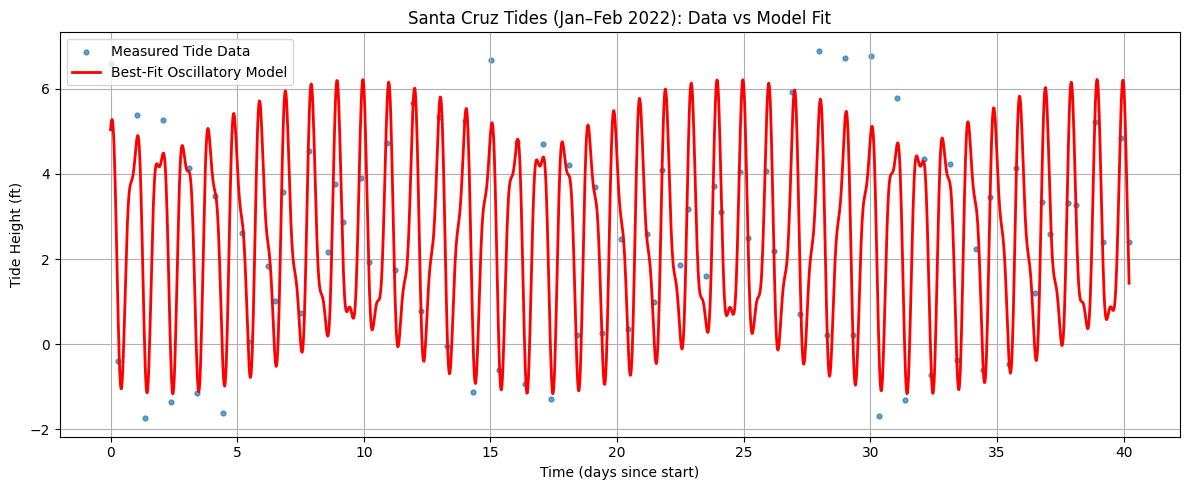

In [7]:
t_fit = np.linspace(t.min(), t.max(), 2000)
y_fit = tide_model(t_fit, *params)

plt.figure(figsize=(12, 5))

plt.scatter(t, y, s=12, alpha=0.7, 
            label="Measured Tide Data")
plt.plot(t_fit, y_fit, 'r-', linewidth=2, 
         label="Best-Fit Oscillatory Model")

plt.xlabel("Time (days since start)")
plt.ylabel("Tide Height (ft)")
plt.title("Santa Cruz Tides (Jan–Feb 2022): Data vs Model Fit")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("tide_fit_plot.pdf")
plt.show()

In [9]:
model_values = tide_model(t, *params)
residuals = y - model_values

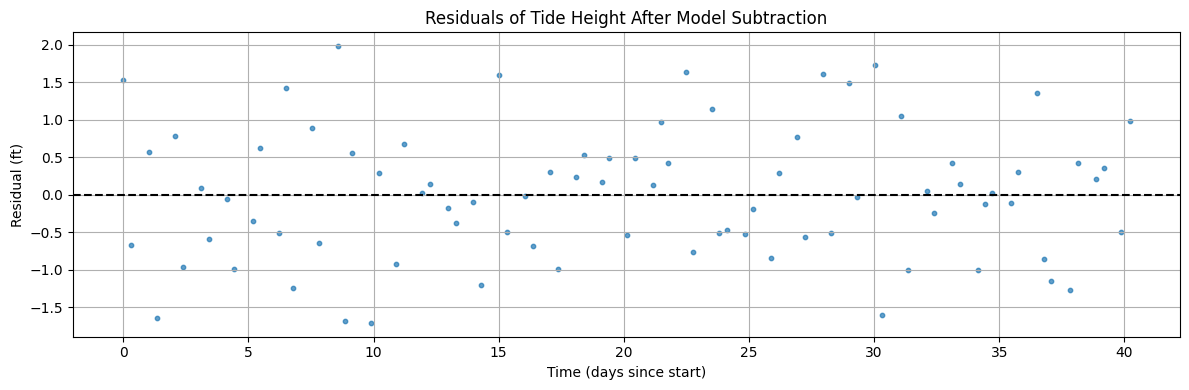

In [10]:
plt.figure(figsize=(12, 4))
plt.scatter(t, residuals, s=10, alpha=0.7)
plt.axhline(0, color="black", linestyle="--")

plt.xlabel("Time (days since start)")
plt.ylabel("Residual (ft)")
plt.title("Residuals of Tide Height After Model Subtraction")
plt.grid(True)

plt.tight_layout()
plt.savefig("tide_residuals_vs_time.pdf")
plt.show()

In [11]:
sigma_meas = 0.25
sigma_tot = np.std(residuals, ddof=1)

print(f"Total scatter of residuals (sigma_tot): {sigma_tot:.3f} ft")
print(f"Assumed measurement error (sigma_meas): {sigma_meas:.3f} ft")

Total scatter of residuals (sigma_tot): 0.877 ft
Assumed measurement error (sigma_meas): 0.250 ft


In [12]:
if sigma_tot > sigma_meas:
    sigma_intrinsic = np.sqrt(sigma_tot**2 - sigma_meas**2)
else:
    sigma_intrinsic = 0.0

print(f"Estimated intrinsic scatter (sigma_intrinsic): {sigma_intrinsic:.3f} ft")

Estimated intrinsic scatter (sigma_intrinsic): 0.840 ft


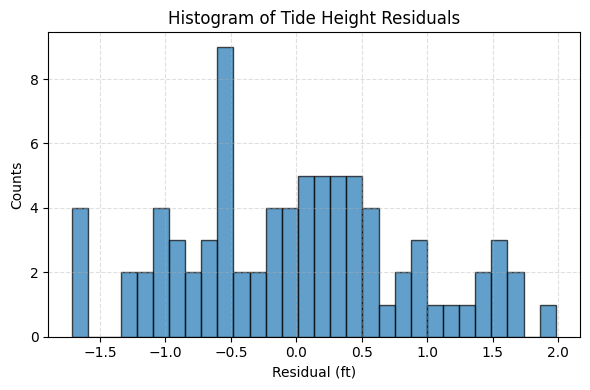

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)

plt.xlabel("Residual (ft)")
plt.ylabel("Counts")
plt.title("Histogram of Tide Height Residuals")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("tide_residuals_histogram.pdf")
plt.show()

In [14]:
tsunami_height_increase = 2.0

N_sigma_tot = tsunami_height_increase / sigma_tot

if sigma_intrinsic > 0:
    N_sigma_intrinsic = tsunami_height_increase / sigma_intrinsic
else:
    N_sigma_intrinsic = np.inf

print(f"Tsunami significance relative to total scatter: {N_sigma_tot:.2f} σ")
print(f"Tsunami significance relative to intrinsic scatter: {N_sigma_intrinsic:.2f} σ")

Tsunami significance relative to total scatter: 2.28 σ
Tsunami significance relative to intrinsic scatter: 2.38 σ


In [15]:
residuals_with_outlier = np.append(residuals, tsunami_height_increase)

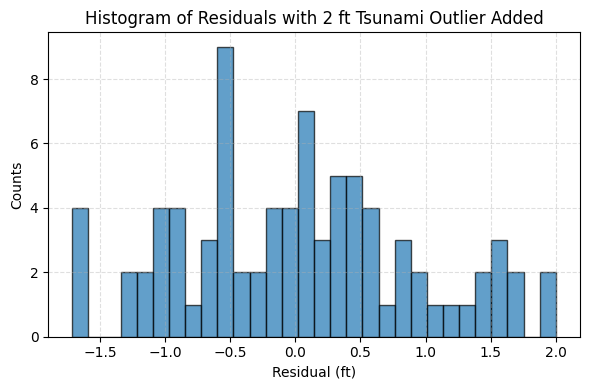

In [16]:
plt.figure(figsize=(6, 4))
plt.hist(residuals_with_outlier, bins=30, edgecolor="black", alpha=0.7)

plt.xlabel("Residual (ft)")
plt.ylabel("Counts")
plt.title("Histogram of Residuals with 2 ft Tsunami Outlier Added")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("tide_residuals_histogram_with_tsunami.pdf")
plt.show()